# Selección del clasificador

Alfredo Rodríguez Magdalena ©

In [1]:
import warnings
warnings.filterwarnings("ignore")

import mat73
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import pandas as pd
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

## Importación de los datos de entrenamiento

In [6]:
data = mat73.loadmat(r'../datos/experimento3_sep.mat')
labels = scipy.io.loadmat(r'../datos/labelsExperimento3.mat')
Vr14 = scipy.io.loadmat(r'../datos/Vr14.mat')

X = data["X"]
U = data["U"]
N = data["N"]
Y = labels['Y']
Vr14 = Vr14['Vr']

tm = 5e-3 # Tiempo de muestreo

print(f"Dimensiones de las etiquetas : {Y.shape}")
print(f"Dimensiones de la matriz de cambio de base : {Vr14.shape}")

Dimensiones de las etiquetas : (11953, 1)
Dimensiones de la matriz de cambio de base : (15, 500)


In [5]:
# Seleccionar 10 índices aleatorios
#indices_aleatorios = np.random.choice(X.shape[0], 10, replace=False)

# Seleccionar los perfiles, sus etiquetas y velocidades correspondientes
#perfiles_aleatorios = X[indices_aleatorios]
#etiquetas_aleatorias = Y[indices_aleatorios]
#velocidades_aleatorias = U[indices_aleatorios, 0]

# Crear un DataFrame con los perfiles, las etiquetas y las velocidades
#perfiles_df = pd.DataFrame(perfiles_aleatorios, columns=[f"Feature_{i}" for i in range(X.shape[1])])
#perfiles_df['Etiqueta'] = etiquetas_aleatorias
#perfiles_df['Velocidad'] = velocidades_aleatorias

# Exportar el DataFrame a un archivo CSV
#perfiles_df.to_csv("perfiles_aleatorios.csv", index=False)

In [7]:
# Importar la matriz de perfiles aleatorios desde el archivo CSV
perfiles_df = pd.read_csv("perfiles_aleatorios.csv")

# Extraer los perfiles (todas las columnas excepto 'Etiqueta' y 'Velocidad')
perfiles = perfiles_df.drop(columns=['Etiqueta', 'Velocidad']).values

print(perfiles.shape)

alphaAA = Vr14 @ perfiles.T
print(alphaAA)

(10, 500)
[[-3.48529220e+01 -4.42027596e+01 -6.51193539e+01 -5.61530752e+01
  -3.70385719e+01 -6.01103020e+01 -5.94888948e+01 -5.32693057e+01
  -4.25581166e+01 -6.34096732e+01]
 [-8.29756250e+00 -9.76132300e+00 -2.73512059e-01  1.77786882e+00
  -5.41344405e+00  8.59030633e-01  2.91339550e+00  2.82780438e+00
  -9.39986693e+00 -4.19671224e+00]
 [ 2.61484352e+00  1.07107172e+00  8.87529617e+00  6.03876313e+00
   5.91838565e+00  6.07161613e+00  9.20076719e+00  5.24154723e+00
   6.95710775e-01  9.27863157e+00]
 [ 3.43905766e+00  2.21071489e+00  5.34466983e+00  5.49256412e+00
   5.02509853e+00  3.44031883e+00  3.99688151e+00  6.64249298e+00
   1.83122646e+00  2.44476873e+00]
 [ 1.28839320e+00  5.75140623e-01 -1.08191729e+00  7.67473832e-01
   1.21045494e+00  6.20301323e-01 -3.84150662e-01 -6.91812992e-01
   1.09950244e+00  5.09690786e-01]
 [-1.35932977e+00 -1.43873485e+00 -6.66868762e+00  4.73908696e-02
  -2.76716576e+00  1.06324085e-01 -5.06183149e+00  4.11752280e-01
  -1.57775821e+00 -9.92

In [8]:
scalerX = StandardScaler()
Xnormalizado = scalerX.fit_transform(X)
Unormalizado = U[:,0] / 1000 # Se expresa en m/s

In [9]:
# DS1 -> Todos los datos sin tratar
X1 = np.hstack((Xnormalizado, Unormalizado.reshape(-1,1)))

print(f"Dimensiones de dataset 1 : {X1.T.shape} (características, muestras)")

Dimensiones de dataset 1 : (501, 11953) (características, muestras)


In [10]:
# DS2 -> Datos en la base de Vr14
X2 = Vr14 @ X.T
X2 = np.hstack((X2.T, U[:,0].reshape(-1,1)))

print(f"Dimensiones de la matriz de cambio de base : {Vr14.shape}")
print(f"Dimensiones de dataset 2 : {X2.T.shape} (características, muestras)")

Dimensiones de la matriz de cambio de base : (15, 500)
Dimensiones de dataset 2 : (16, 11953) (características, muestras)


In [11]:
# DS3 -> Datos deducidos a partir de la etapa de extracción de características superficial
X3 = data["F"]
X3 = np.hstack((X3, U[:,0].reshape(-1,1)))

print(f"Dimensiones de dataset 3 : {X3.T.shape} (características, muestras)")

Dimensiones de dataset 3 : (3, 11953) (características, muestras)


In [12]:
datasets = {"DS1" : X1, 
            "DS2" : X2, 
            "DS3" : X3}

## Entrenamiento de modelos

In [13]:
semilla = 92
np.random.seed(semilla) # Semilla para reproducibilidad

In [14]:
# Diccionario con los algoritmos de clasificación
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Gaussian Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "SGD Classifier": SGDClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "ANN": MLPClassifier(max_iter=300),
}

In [15]:
print(np.ravel(Y).shape)

(11953,)


In [16]:
# Función para entrenar y evaluar cada algoritmo en un dataset
results = []
mejorModelo = None

for dataset_name, XX in datasets.items(): 
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(XX, np.ravel(Y), test_size=0.3, random_state=semilla)

    for model_name, model in classifiers.items():
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Medir tiempo de predicción
        start_time = time.time()
        y_pred = model.predict(X_test)
        prediction_time = time.time() - start_time  # Tiempo en segundos

        if model_name == "Decision Tree" and dataset_name == "DS2":
            print(X_test.shape)
            # Crear una matriz con 10 muestras del conjunto de test y su predicción por el modelo
            #muestras_predicciones = np.hstack((X_test, y_pred.reshape(-1, 1)))

            # Convertir la matriz a un DataFrame
            #muestras_predicciones_df = pd.DataFrame(muestras_predicciones, columns=[f"Feature_{i}" for i in range(X_test.shape[1])] + ["Prediction"])

            # Exportar el DataFrame a un archivo CSV
            #muestras_predicciones_df.to_csv("muestras_predicciones.csv", index=False)
            
            tree_json = model.tree_.__getstate__()
            tree_json['nodes'] = tree_json['nodes'].tolist()
            tree_json['values'] = tree_json['values'].tolist()
            with open(f"decision_tree_{dataset_name}.json", "w") as f:
                json.dump(tree_json, f)

        # Calcular las métricas
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "F1-Score": report["weighted avg"]["f1-score"],
            "Prediction Time [ms]": prediction_time * 10 # Más tarde se multiplica por 100 para obtener ms
        })

# Convertir resultados a un DataFrame
results_df = pd.DataFrame(results)


(3586, 16)


In [17]:
numeric_columns = results_df.select_dtypes(include=[np.number]).columns
results_df[numeric_columns] = results_df[numeric_columns].map(lambda x: f"{x*100:.2f}")

results_df.to_csv("resultadosClasificacion.csv", index=False)

In [18]:
print(Y.shape)
print(U[:,0].shape)

(11953, 1)
(11953,)


Text(0, 0.5, 'Velocidad [m/s]')

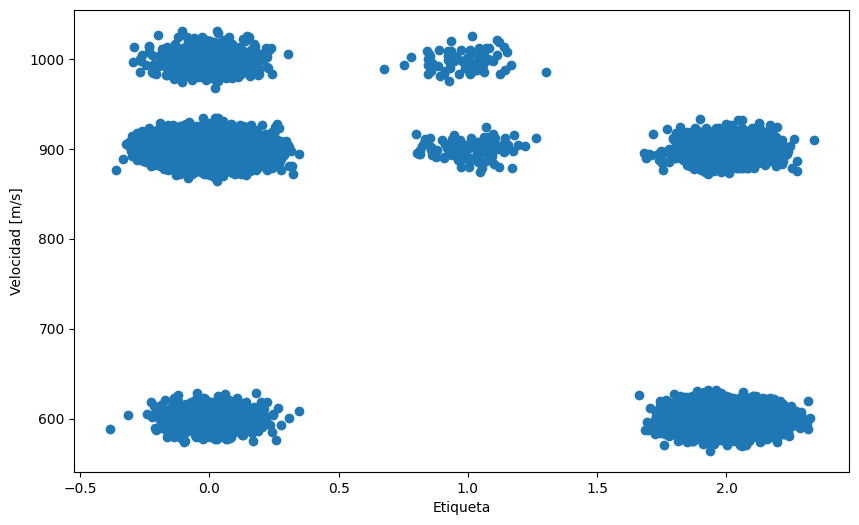

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(Y.ravel()+0.1*np.random.randn(Y.shape[0]), U[:,0].ravel()+10*np.random.randn(U[:,0].shape[0]))
plt.xlabel('Etiqueta')
plt.ylabel('Velocidad [m/s]')

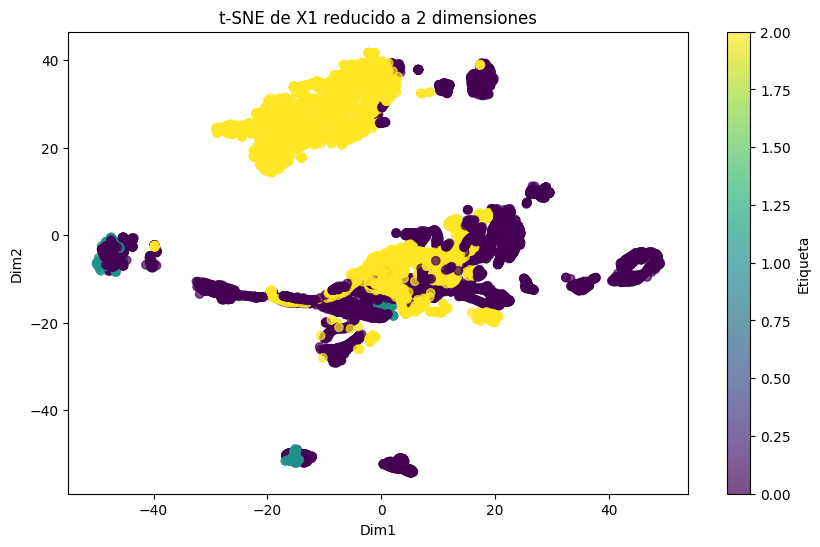

In [20]:
from sklearn.manifold import TSNE

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=92, perplexity=300)
X1_tsne = tsne.fit_transform(X2)

# Crear un DataFrame con los resultados de t-SNE y las etiquetas
tsne_df = pd.DataFrame(X1_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Etiqueta'] = np.ravel(Y)

# Visualizar los resultados
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_df['Dim1'], tsne_df['Dim2'], c=tsne_df['Etiqueta'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Etiqueta')
plt.xlabel('Dim1')
plt.ylabel('Dim2')
plt.title('t-SNE de X1 reducido a 2 dimensiones')
plt.show()